<a href="https://colab.research.google.com/github/henricovicentini/desafio_jacto_ia/blob/main/Estagio_Jacto_Intelig%C3%AAncia_Artifical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Dependencias

!pip install -q pandas matplotlib fastapi uvicorn "sqlalchemy>=1.4" pymongo pydantic nest_asyncio dnspython requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 24.2 MB/s eta 0:00:00


In [3]:
# Baixar e preparar cloudflared
!curl -s https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -L -o cloudflared
!chmod +x cloudflared


In [5]:
# Imports organizados e carregamento do dataset ===
import os
import re
import socket
import threading
import subprocess

import pandas as pd
import matplotlib.pyplot as plt

# FastAPI / execução
import nest_asyncio
import uvicorn
from fastapi import FastAPI, HTTPException, Depends
from fastapi.middleware.cors import CORSMiddleware

# Pydantic / tipagem
from pydantic import BaseModel, Field
from typing import List, Optional

# SQL (relacional)
from sqlalchemy import create_engine, Column, Integer, String, Float
from sqlalchemy.orm import declarative_base, sessionmaker, Session

# NoSQL (MongoDB)
from pymongo import MongoClient
from bson import ObjectId
from bson.errors import InvalidId

# Utilitários
import requests

# Carregar dataset (ajuste o caminho se necessário)
dataset_path = "CarsData.csv"
if not os.path.exists(dataset_path):
    print(f"Atenção: não encontrei '{dataset_path}'. Faça upload do arquivo no Colab (Files -> Upload) ou ajuste o caminho.")
else:
    dataset = pd.read_csv(dataset_path)
    display(dataset.head())


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,I10,2017,7495,Manual,11630,Petrol,145,60.1,1.0,hyundi
1,Polo,2017,10989,Manual,9200,Petrol,145,58.9,1.0,volkswagen
2,2 Series,2019,27990,Semi-Auto,1614,Diesel,145,49.6,2.0,BMW
3,Yeti Outdoor,2017,12495,Manual,30960,Diesel,150,62.8,2.0,skoda
4,Fiesta,2017,7999,Manual,19353,Petrol,125,54.3,1.2,ford



## Desafio 1: Ler os dados do conjunto de dados de carros (abaixo), gerar um gráfico de barras e identificar alguma descoberta em cima desse resultado. Dica: utilize o Google Colab.

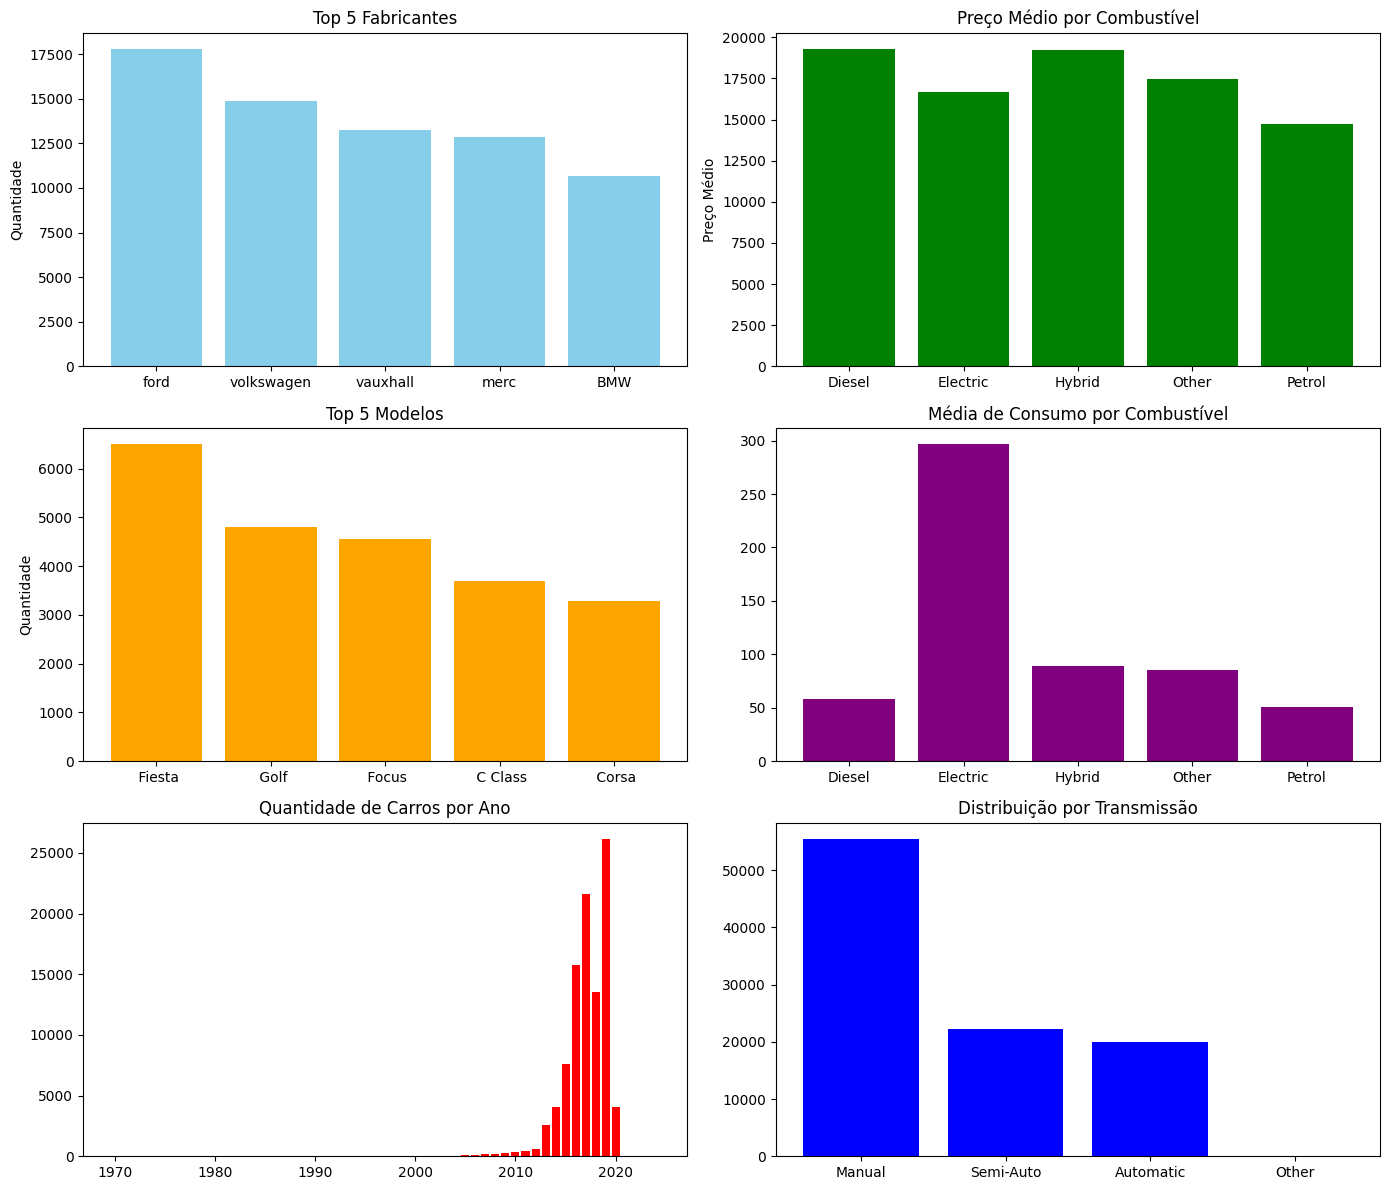

In [6]:

fig, axes = plt.subplots(3, 2, figsize=(14,12))

# Gráfico 1: Top 5 Fabricantes
fabricante_contagem = dataset['Manufacturer'].value_counts().head(5)
axes[0,0].bar(fabricante_contagem.index, fabricante_contagem.values, color="skyblue")
axes[0,0].set_title("Top 5 Fabricantes")
axes[0,0].set_ylabel("Quantidade")

# Gráfico 2: Preço Médio por Combustível
preco_combustivel = dataset.groupby("fuelType")["price"].mean()
axes[0,1].bar(preco_combustivel.index, preco_combustivel.values, color="green")
axes[0,1].set_title("Preço Médio por Combustível")
axes[0,1].set_ylabel("Preço Médio")

# Gráfico 3: Top 5 Modelos
modelo_mais_vendido = dataset['model'].value_counts().head(5)
axes[1,0].bar(modelo_mais_vendido.index, modelo_mais_vendido.values, color="orange")
axes[1,0].set_title("Top 5 Modelos")
axes[1,0].set_ylabel("Quantidade")

# Gráfico 4: Consumo Médio por Combustível
media_consumo = dataset.groupby("fuelType")["mpg"].mean()
axes[1,1].bar(media_consumo.index, media_consumo.values, color="purple")
axes[1,1].set_title("Média de Consumo por Combustível")

# Gráfico 5: Carros por Ano de Fabricação
carros_por_ano = dataset["year"].value_counts().sort_index()
axes[2,0].bar(carros_por_ano.index, carros_por_ano.values, color="red")
axes[2,0].set_title("Quantidade de Carros por Ano")

# Gráfico 6: Distribuição por Tipo de Transmissão
carros_por_transmissao = dataset["transmission"].value_counts()
axes[2,1].bar(carros_por_transmissao.index, carros_por_transmissao.values, color="blue")
axes[2,1].set_title("Distribuição por Transmissão")

plt.tight_layout()
plt.show()



## Desafio 2: Crie uma API que tenha os métodos GET, POST, PUT, DELETE que realizem ações em um banco de dados (contexto: Carros, ex.: get cars, post cars, put car, delete car, com no mínimo 3 campos e com tipos de campos diferentes texto, número, etc):

2.1 Banco relacional (qualquer um)

2.2 Banco não relacional (qualquer um)

2.3 Exiba em um postman ou Swagger mostrando a execução da API e os dados no banco

In [7]:
# API Carros - Banco Relacional (SQLite + SQLAlchemy)

# 1) Banco Relacional (SQLite)
DATABASE_URL = "sqlite:///./cars.db"
engine = create_engine(DATABASE_URL, connect_args={"check_same_thread": False})
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
Base = declarative_base()

class CarSQL(Base):
    __tablename__ = "cars"
    id = Column(Integer, primary_key=True, index=True)
    manufacturer = Column(String, index=True)
    year = Column(Integer)
    price = Column(Float)

Base.metadata.create_all(bind=engine)

# 2) Schemas
class CarSchema(BaseModel):
    manufacturer: str
    year: int
    price: float

class CarResponse(CarSchema):
    id: int
    class Config:
        from_attributes = True

# 3) FastAPI
app = FastAPI(title="API Carros - SQLite (Relacional)")

def get_db():
    db = SessionLocal()
    try:
        yield db
    finally:
        db.close()

@app.get("/")
def root():
    return {"message": "Bem-vindo à API de Carros (SQLite)!", "swagger": "/docs"}

@app.post("/cars", response_model=CarResponse)
def create_car_sql(car: CarSchema, db: Session = Depends(get_db)):
    db_car = CarSQL(**car.dict())
    db.add(db_car)
    db.commit()
    db.refresh(db_car)
    return db_car

@app.get("/cars", response_model=List[CarResponse])
def read_cars_sql(db: Session = Depends(get_db)):
    return db.query(CarSQL).all()

@app.put("/cars/{car_id}", response_model=CarResponse)
def update_car_sql(car_id: int, car: CarSchema, db: Session = Depends(get_db)):
    db_car = db.query(CarSQL).filter(CarSQL.id == car_id).first()
    if not db_car:
        raise HTTPException(status_code=404, detail="Carro não encontrado (SQL)")
    for k, v in car.dict().items():
        setattr(db_car, k, v)
    db.commit()
    db.refresh(db_car)
    return db_car

@app.delete("/cars/{car_id}")
def delete_car_sql(car_id: int, db: Session = Depends(get_db)):
    db_car = db.query(CarSQL).filter(CarSQL.id == car_id).first()
    if not db_car:
        raise HTTPException(status_code=404, detail="Carro não encontrado (SQL)")
    db.delete(db_car)
    db.commit()
    return {"message": "Carro deletado com sucesso (SQL)"}

# 4) Rodando no Colab com Cloudflare
nest_asyncio.apply()

def find_free_port(start=8000, end=8100):
    for port in range(start, end):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("0.0.0.0", port))
                return port
            except OSError:
                continue
    raise RuntimeError("Sem portas livres disponíveis!")

port = find_free_port()

def run():
    uvicorn.run(app, host="0.0.0.0", port=port, log_level="info")

threading.Thread(target=run, daemon=True).start()

print("Criando túnel com Cloudflare...")

process = subprocess.Popen(
    ["./cloudflared", "tunnel", "--url", f"http://localhost:{port}", "--no-autoupdate"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)

url = None
for line in process.stdout:
    # mostra logs do cloudflared para ajudar no debug
    print("[CLOUDFLARED]", line.strip())
    if "trycloudflare.com" in line:
        match = re.search(r"https://[0-9a-zA-Z.-]+\.trycloudflare\.com", line)
        if match:
            url = match.group(0)
            print("Túnel ativo")
            print("URL pública:", url)
            print("Swagger docs:", url + "/docs")
            break

if not url:
    print("Não foi possível capturar a URL do Cloudflared automaticamente. Verifique os logs acima.")
    print("Se o tunnel foi criado, procure a URL nos logs do cloudflared ou no output do processo.")

INFO:     Started server process [421]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Criando túnel com Cloudflare...
[CLOUDFLARED] 2025-09-15T14:28:29Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
[CLOUDFLARED] 2025-09-15T14:28:29Z INF Requesting new quick Tunnel on trycloudflare.com...
[CLOUDFLARED] 2025-09-15T14:28:33Z INF +--------------------------------------------------------------------------------------------+
[CLOUDFLARED] 2025-09-15T14:28:33Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachabl

In [8]:
# API Carros - Banco Não Relacional (MongoDB Atlas)

# 1) Banco MongoDB

MONGO_URI = "mongodb+srv://<USUARIO>:<SENHA>@cluster0.uwad0mc.mongodb.net/?retryWrites=true&w=majority"
client = MongoClient(MONGO_URI)
db = client["cars_db"]
cars_collection = db["cars"]

# 2) Schemas
class CarSchema(BaseModel):
    manufacturer: str
    year: int
    price: float

class CarResponse(CarSchema):
    id: str
    class Config:
        from_attributes = True

# 3) FastAPI
app = FastAPI(title="API Carros - MongoDB Atlas (NoSQL)")

@app.get("/")
def root():
    return {"message": "Bem-vindo à API de Carros (MongoDB)!", "swagger": "/docs"}

@app.post("/cars", response_model=CarResponse)
def create_car_mongo(car: CarSchema):
    result = cars_collection.insert_one(car.dict())
    return CarResponse(id=str(result.inserted_id), **car.dict())

@app.get("/cars", response_model=List[CarResponse])
def read_cars_mongo():
    cars = []
    for car in cars_collection.find():
        cars.append(CarResponse(
            id=str(car["_id"]),
            manufacturer=car["manufacturer"],
            year=car["year"],
            price=car["price"]
        ))
    return cars

@app.put("/cars/{car_id}", response_model=CarResponse)
def update_car_mongo(car_id: str, car: CarSchema):
    result = cars_collection.update_one({"_id": ObjectId(car_id)}, {"$set": car.dict()})
    if result.matched_count == 0:
        raise HTTPException(status_code=404, detail="Carro não encontrado (MongoDB)")
    updated = cars_collection.find_one({"_id": ObjectId(car_id)})
    return CarResponse(
        id=str(updated["_id"]),
        manufacturer=updated["manufacturer"],
        year=updated["year"],
        price=updated["price"]
    )

@app.delete("/cars/{car_id}")
def delete_car_mongo(car_id: str):
    result = cars_collection.delete_one({"_id": ObjectId(car_id)})
    if result.deleted_count == 0:
        raise HTTPException(status_code=404, detail="Carro não encontrado (MongoDB)")
    return {"message": "Carro deletado com sucesso (MongoDB)"}

# 4) Rodando no Colab com Cloudflare
nest_asyncio.apply()

def find_free_port(start=8000, end=8100):
    for port in range(start, end):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("0.0.0.0", port))
                return port
            except OSError:
                continue
    raise RuntimeError("Sem portas livres disponíveis!")

port = find_free_port()

def run():
    uvicorn.run(app, host="0.0.0.0", port=port, log_level="info")

threading.Thread(target=run, daemon=True).start()

print("Criando túnel com Cloudflare...")

process = subprocess.Popen(
    ["./cloudflared", "tunnel", "--url", f"http://localhost:{port}", "--no-autoupdate"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

url = None
for line in process.stdout:
    print("[CLOUDFLARED]", line.strip())  # debug
    if "trycloudflare.com" in line:
        match = re.search(r"https://[0-9a-zA-Z.-]+\.trycloudflare\.com", line)
        if match:
            url = match.group(0)
            print("Túnel ativo")
            print("URL pública:", url)
            print("Swagger docs:", url + "/docs")
            break

if not url:
    print("Não foi possível capturar a URL do Cloudflared automaticamente. Veja os logs acima.")

Criando túnel com Cloudflare...


INFO:     Started server process [421]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


[CLOUDFLARED] 2025-09-15T14:28:43Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
[CLOUDFLARED] 2025-09-15T14:28:43Z INF Requesting new quick Tunnel on trycloudflare.com...
[CLOUDFLARED] 2025-09-15T14:28:45Z INF +--------------------------------------------------------------------------------------------+
[CLOUDFLARED] 2025-09-15T14:28:45Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
[CLOUDFLARED] 2025-09-15T


##Desafio 3: Implemente alguma ferramenta existente no mercado de Inteligência Artificial (qualquer ferramenta, tente demonstrar um caso de uso). Dicas: como contribuir no contexto da agricultura digital

Tecnologias:

Código em Python no Jupyter Notebook

- API para o desafio 2: C#, NodeJS, Java, Python



### Bibliotecas

In [9]:
#https://www.kaggle.com/datasets/mathurinache/agricultura-digital -> link do Dataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


### Imporando o dataset e exibindo o cabeçalho




In [11]:
dataset = pd.read_csv("dataset_tomate.csv")

dataset.head()

,id,trat,NDVI_d28,SAVI_d28,GNDVI_d28,MCARI1_d28,SR_d28,NDVI_d01,SAVI_d01,GNDVI_d01,...,SAVI_d04,GNDVI_d04,MCARI1_d04,SR_d04,NDVI_d08,SAVI_d08,GNDVI_d08,MCARI1_d08,SR_d08,Classe
0,1,102,0.798284,1.197380,0.692652,16710.29721,9.728142,0.729767,1.094620,0.698726,...,1.069718,0.662425,13090.11459,6.216968,0.684125,1.026146,0.636865,13352.81776,5.421333,1
1,2,11,0.806955,1.210392,0.705323,19513.85630,10.557411,0.774359,1.161514,0.717367,...,1.166604,0.680269,22731.09954,8.380453,0.725521,1.088240,0.669113,16190.82038,6.491860,0
2,3,103,0.825104,1.237610,0.708468,18074.06986,11.141408,0.786941,1.180385,0.730471,...,1.096008,0.680238,12330.21702,6.670915,0.728171,1.092214,0.655206,15313.16198,6.551268,1
3,4,112,0.788884,1.183279,0.664787,16226.23017,8.990752,0.743874,1.115782,0.690141,...,1.061948,0.644786,12085.07787,6.017714,0.728161,1.092201,0.640739,16562.17418,6.608121,1
4,5,114,0.764986,1.147432,0.673490,14920.80711,8.269806,0.715948,1.073894,0.695619,...,1.032176,0.660206,10053.17885,5.571702,0.694320,1.041437,0.642373,13760.95583,5.665567,1


### Excluir colunas que não ajudam na predição

In [12]:
dataset = dataset.drop(["id", "trat"], axis=1)


### 2. Definir X e y


In [13]:
X = dataset.drop("Classe", axis=1)  # features
y = dataset["Classe"]               # alvo

print(f"Quantidade de dados: {len(X)}")
print(f"Formato dos dados: {X.shape}")
print(f"Formato do y: {y.shape}")


Quantidade de dados: 132
Formato dos dados: (132, 20)
Formato do y: (132,)


### 3. Escalonar os dados

In [14]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



### 4. Separar treino e teste

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


### 5. Criar o KNN

In [16]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

### 6. Avaliar desempenho


In [17]:
y_pred = knn.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {round(acuracia*100, 2)}%")

Acurácia do modelo: 85.19%


### 7. Exemplo de predição

#### Criando um tomate fictício (mesmo número de features do X)

In [18]:

tomate_fake = pd.DataFrame([[
    0.75, 1.1, 0.68, 15000, 9.0,   # d28
    0.70, 1.0, 0.65, 12000, 6.0,   # d01
    0.72, 1.05, 0.66, 13000, 6.5,  # d04
    0.71, 1.07, 0.64, 13500, 6.2   # d08
]], columns=X.columns)  # usa as mesmas colunas do dataset

# Escalar e prever
tomate_fake_s = scaler.transform(tomate_fake)
predicao_fake = knn.predict(tomate_fake_s)

print(" Tomate Classe prevista:", predicao_fake[0])


 Tomate Classe prevista: 1


In [19]:
# Criando tomate fictício (tendência Classe 0)
tomate_fake0 = pd.DataFrame([[
    0.55, 0.80, 0.45, 8000, 3.5,    # d28
    0.50, 0.75, 0.40, 7000, 3.0,    # d01
    0.52, 0.78, 0.42, 7500, 3.2,    # d04
    0.51, 0.76, 0.41, 7200, 3.1     # d08
]], columns=X.columns)

# Escalar e prever
tomate_fake0_s = scaler.transform(tomate_fake0)
predicao_fake0 = knn.predict(tomate_fake0_s)

print(" Tomate Classe prevista:", predicao_fake0[0])


 Tomate Classe prevista: 0
